In [1]:
# Import libraries
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import pandas as pd
from pathlib import Path
from tqdm import tqdm
import os
import pickle
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.utils import class_weight
from sklearn.metrics import precision_recall_curve, f1_score, classification_report

from tensorflow.keras import layers, models
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, Dense, Dropout, BatchNormalization, Conv1D, GlobalMaxPooling1D, MaxPooling1D, LSTM
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import AUC, Precision, Recall
import tensorflow.keras.backend as K

In [6]:
# Charge X and y data that are in .npy format
X = np.load('../../../OpenFace Embeddings/X.npy')
y = np.load('../../../OpenFace Embeddings/y.npy')
X.shape, y.shape

((241, 300, 30), (241,))

In [7]:
type(X)

numpy.ndarray

In [8]:
# Value counts of y
print(pd.Series(y).value_counts())

3    61
2    61
1    60
0    59
Name: count, dtype: int64


In [10]:
# Divide data in train, val and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42, stratify=y_train)
X_train.shape, X_val.shape, X_test.shape, y_train.shape, y_val.shape, y_test.shape
#X_train.shape, X_test.shape, y_train.shape, y_test.shape

((153, 300, 30), (39, 300, 30), (49, 300, 30), (153,), (39,), (49,))

In [12]:
y_train

array([3, 2, 2, 0, 2, 2, 2, 1, 0, 2, 1, 3, 3, 3, 0, 1, 3, 3, 0, 0, 2, 3,
       1, 2, 2, 1, 3, 3, 1, 0, 3, 0, 1, 0, 1, 1, 1, 0, 2, 0, 3, 1, 3, 0,
       1, 0, 2, 1, 1, 0, 2, 2, 0, 2, 2, 0, 0, 2, 0, 1, 2, 1, 1, 3, 0, 1,
       1, 0, 0, 3, 2, 1, 1, 2, 3, 3, 2, 3, 3, 2, 0, 0, 0, 3, 3, 1, 2, 3,
       1, 3, 0, 1, 0, 0, 1, 2, 1, 2, 3, 0, 2, 3, 1, 0, 2, 3, 1, 2, 3, 3,
       1, 2, 0, 0, 3, 0, 0, 2, 2, 3, 1, 1, 2, 0, 2, 0, 2, 1, 2, 3, 1, 0,
       0, 3, 1, 1, 3, 3, 3, 2, 1, 3, 0, 3, 2, 3, 2, 2, 3, 3, 1, 0, 1])

In [11]:
# Calculate class weights
class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)
class_weights = dict(enumerate(class_weights))

In [8]:
# Parámetros
n_components = 30  # número de componentes disponibles
n_models = 1      # número de modelos en el ensemble
components_per_model = 30  # cuantos componentes (features) por modelo

models = []
selected_components = []
histories = []

# Callback EarlyStopping y ReduceLROnPlateau
early_stopping = EarlyStopping(monitor='val_loss', patience=50, restore_best_weights=True, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, verbose=1)

# Definimos el modelo CNN
def build_cnn_model(input_shape):
    model = Sequential()
    model.add(Conv1D(128, kernel_size=5, activation='relu', padding='same', input_shape=input_shape))
    model.add(BatchNormalization())
    model.add(Dropout(0.3))
    
    model.add(Conv1D(256, kernel_size=3, activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(Dropout(0.3))
    
    model.add(Conv1D(256, kernel_size=3, activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(Dropout(0.3))

    model.add(GlobalMaxPooling1D())

    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))

    model.add(Dense(4, activation='softmax'))  # Cambia 4 por el número de clases que tengas

    model.compile(loss='sparse_categorical_crossentropy', optimizer=Adam(0.0005), metrics=['accuracy'])
    return model

# Entrenamiento de ensemble
for i in range(n_models):
    print(f"Entrenando modelo {i+1}/{n_models}")
    
    # Elegimos aleatoriamente componentes
    components_idx = np.random.choice(n_components, components_per_model, replace=False)
    selected_components.append(components_idx)
    
    # Seleccionamos esos componentes
    X_train_selected = X_train[:, :, components_idx]  # (samples, 300, components_per_model)
    X_val_selected = X_val[:, :, components_idx]

    # Creamos y entrenamos el modelo
    model = build_cnn_model((X_train_selected.shape[1], X_train_selected.shape[2]))
    
    history = model.fit(
        X_train_selected,
        y_train,
        class_weight=class_weights,
        epochs=500,
        batch_size=32,
        validation_data=(X_val_selected, y_val),
        callbacks=[early_stopping, reduce_lr],
        verbose=1
    )
    
    models.append(model)
    histories.append(history)

Entrenando modelo 1/1
Epoch 1/500


d:\OneDrive - Universidad Peruana de Ciencias\Documents\Carrera\2025-1\TP1\videito\env\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 178ms/step - accuracy: 0.2295 - loss: 10.5077 - val_accuracy: 0.2821 - val_loss: 1.3931 - learning_rate: 5.0000e-04
Epoch 2/500
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 132ms/step - accuracy: 0.3011 - loss: 6.7410 - val_accuracy: 0.1538 - val_loss: 1.3933 - learning_rate: 5.0000e-04
Epoch 3/500
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 123ms/step - accuracy: 0.3364 - loss: 4.8622 - val_accuracy: 0.2308 - val_loss: 1.3992 - learning_rate: 5.0000e-04
Epoch 4/500
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 123ms/step - accuracy: 0.3255 - loss: 4.3750 - val_accuracy: 0.2308 - val_loss: 1.4008 - learning_rate: 5.0000e-04
Epoch 5/500
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 121ms/step - accuracy: 0.3060 - loss: 3.3610 - val_accuracy: 0.2564 - val_loss: 1.4011 - learning_rate: 5.0000e-04
Epoch 6/500
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step - accuracy: 0.3133 - loss: 3.0085
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 122ms/step - accuracy: 0.3177 - loss: 2.9599 - 

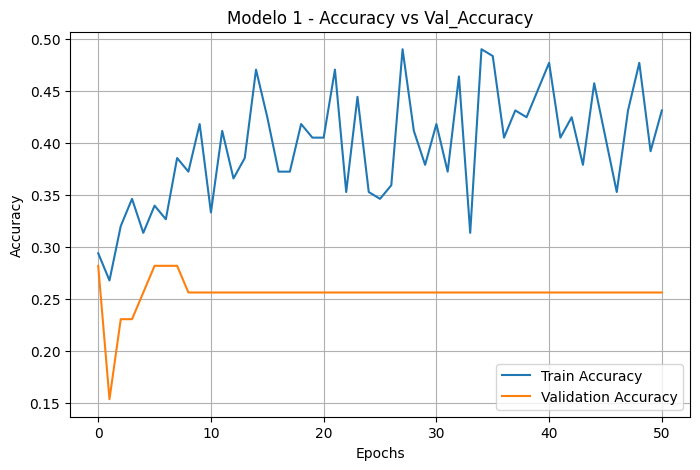

In [9]:
# Graficar accuracy de cada modelo
for i, history in enumerate(histories):
    plt.figure(figsize=(8, 5))
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title(f'Modelo {i+1} - Accuracy vs Val_Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)
    plt.show()

In [10]:
# Predicciones individuales de cada modelo
all_model_preds = []

for idx, model in enumerate(models):
    components_idx = selected_components[idx]
    X_test_selected = X_test[:, :, components_idx]
    
    preds = model.predict(X_test_selected)
    all_model_preds.append(preds)

# Stack de predicciones
all_model_preds = np.stack(all_model_preds, axis=0)  # (n_models, n_samples, 4)

# Promedio (soft voting)
avg_preds = np.mean(all_model_preds, axis=0)  # (n_samples, 4)

# Predicción final: clase con mayor probabilidad
final_preds = np.argmax(avg_preds, axis=1)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step


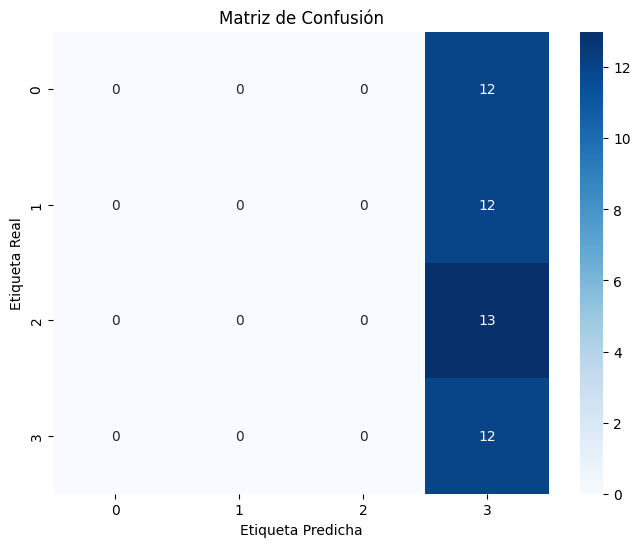

In [11]:
cm = confusion_matrix(y_test, final_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=np.arange(cm.shape[1]), yticklabels=np.arange(cm.shape[0]))
plt.title("Matriz de Confusión")
plt.xlabel("Etiqueta Predicha")
plt.ylabel("Etiqueta Real")
plt.show()

In [12]:
# view classification report
print(classification_report(y_test, final_preds, digits=3))

              precision    recall  f1-score   support

           0      0.000     0.000     0.000        12
           1      0.000     0.000     0.000        12
           2      0.000     0.000     0.000        13
           3      0.245     1.000     0.393        12

    accuracy                          0.245        49
   macro avg      0.061     0.250     0.098        49
weighted avg      0.060     0.245     0.096        49



d:\OneDrive - Universidad Peruana de Ciencias\Documents\Carrera\2025-1\TP1\videito\env\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
d:\OneDrive - Universidad Peruana de Ciencias\Documents\Carrera\2025-1\TP1\videito\env\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
d:\OneDrive - Universidad Peruana de Ciencias\Documents\Carrera\2025-1\TP1\videito\env\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no pr